# Building a CLIP-style Model from Scratch

In [1]:
import os
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Configuration
IMAGE_SIZE = 128
SHAPE_SIZE = 30
OUTPUT_DIR = "data"
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {DEVICE}")

Using device: cuda


## 1. Dataset Generation

We generate a synthetic dataset containing combinations of:
*   **Shapes**: Circle, Square, Triangle
*   **Colors**: 9 distinct colors
*   **Positions**: 9 grid positions (e.g., top_left, center_center)

Each image is paired with a caption like *"a red circle at top left"*.

In [2]:
# distinct colors
COLORS = {
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "blue": (0, 0, 255),
    "yellow": (255, 255, 0),
    "cyan": (0, 255, 255),
    "magenta": (255, 0, 255),
    "orange": (255, 165, 0),
    "purple": (128, 0, 128),
    "brown": (165, 42, 42)
}

SHAPES = ["circle", "square", "triangle"]

# 3x3 grid positions
POSITIONS = {
    "top_left": (0, 0),
    "top_center": (1, 0),
    "top_right": (2, 0),
    "center_left": (0, 1),
    "center_center": (1, 1),
    "center_right": (2, 1),
    "bottom_left": (0, 2),
    "bottom_center": (1, 2),
    "bottom_right": (2, 2)
}

def draw_shape(draw, shape, color, position):
    # Calculate pixel coordinates based on grid position
    cell_size = IMAGE_SIZE // 3
    grid_x, grid_y = POSITIONS[position]

    # Center of the cell
    center_x = grid_x * cell_size + cell_size // 2
    center_y = grid_y * cell_size + cell_size // 2

    half_size = SHAPE_SIZE // 2

    if shape == "circle":
        draw.ellipse(
            [center_x - half_size, center_y - half_size, center_x + half_size, center_y + half_size],
            fill=COLORS[color]
        )
    elif shape == "square":
        draw.rectangle(
            [center_x - half_size, center_y - half_size, center_x + half_size, center_y + half_size],
            fill=COLORS[color]
        )
    elif shape == "triangle":
        # Upward pointing triangle
        points = [
            (center_x, center_y - half_size), # Top
            (center_x - half_size, center_y + half_size), # Bottom left
            (center_x + half_size, center_y + half_size)  # Bottom right
        ]
        draw.polygon(points, fill=COLORS[color])

def generate_dataset():
    if not os.path.exists(IMAGES_DIR):
        os.makedirs(IMAGES_DIR)

    dataset = []

    # Generate all combinations
    for shape in SHAPES:
        for color_name, color_rgb in COLORS.items():
            for pos_name, _ in POSITIONS.items():

                # Create image
                img = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), "white")
                draw = ImageDraw.Draw(img)

                draw_shape(draw, shape, color_name, pos_name)

                # Construct filename and caption
                filename = f"{color_name}_{shape}_{pos_name}.png"
                filepath = os.path.join(IMAGES_DIR, filename)

                # Save image
                img.save(filepath)

                # Create caption (e.g., "a red circle at top left")
                readable_pos = pos_name.replace("_", " ")
                caption = f"a {color_name} {shape} at {readable_pos}"

                dataset.append({
                    "image_path": filepath,
                    "caption": caption,
                    "shape": shape,
                    "color": color_name,
                    "position": pos_name
                })

    # Save metadata
    with open(os.path.join(OUTPUT_DIR, "dataset.json"), "w") as f:
        json.dump(dataset, f, indent=2)

    print(f"Generated {len(dataset)} images in {IMAGES_DIR}")

# Run generation
generate_dataset()

Generated 243 images in data/images


## 2. Model Architecture

We define three main components:
1.  **ImageEncoder**: A simple CNN that takes an image (3x128x128) and outputs a vector embedding.
2.  **TextEncoder**: A Transformer-based encoder that takes tokenized text and outputs a vector embedding.
3.  **NanoVLM**: The main model that wraps both encoders and learns a shared embedding space.

In [3]:
class ImageEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        # Input: 3 x 128 x 128
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1) # 16 x 64 x 64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1) # 32 x 32 x 32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # 64 x 16 x 16
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 16 * 16, embedding_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, max_seq_len=20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Simple position embedding
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_seq_len, embed_dim))

        # A single transformer layer for "Nano" feel
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, dim_feedforward=embed_dim*4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, seq_len]
        seq_len = x.size(1)
        x = self.embedding(x) + self.pos_embedding[:, :seq_len, :]
        x = self.transformer(x)
        # Global Average Pooling
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

class NanoVLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64):
        super().__init__()
        self.image_encoder = ImageEncoder(embed_dim)
        self.text_encoder = TextEncoder(vocab_size, embed_dim, embed_dim)
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)

    def forward(self, images, text):
        # Get embeddings
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(text)

        # Normalize
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return image_features, text_features

## 3. Training

We use a **Contrastive Loss** function. For a batch of N image-text pairs, we want the model to maximize the cosine similarity between the correct pairs (diagonal of the similarity matrix) and minimize it for incorrect pairs.

In [4]:
class ShapeDataset(Dataset):
    def __init__(self, data_path, tokenizer, transform=None):
        with open(data_path, "r") as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item["image_path"]
        caption = item["caption"]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        tokens = torch.tensor(self.tokenizer.encode(caption), dtype=torch.long)

        return image, tokens

# Transforms
transform = transforms.Compose([transforms.ToTensor(),])

# Load Data to build tokenizer
with open("data/dataset.json", "r") as f:
    raw_data = json.load(f)
captions = [item["caption"] for item in raw_data]

In [5]:
class SimpleTokenizer:
    def __init__(self, text_data):
        # Build vocabulary from simple split
        words = set()
        for text in text_data:
            words.update(text.lower().split())

        self.vocab = {word: i+1 for i, word in enumerate(sorted(list(words)))} # 0 is padding
        self.vocab["<pad>"] = 0
        self.inv_vocab = {i: w for w, i in self.vocab.items()}

    def encode(self, text, max_len=20):
        tokens = [self.vocab.get(w, 0) for w in text.lower().split()]
        if len(tokens) < max_len:
            tokens += [0] * (max_len - len(tokens))
        else:
            tokens = tokens[:max_len]
        return tokens

    def decode(self, tokens):
        return " ".join([self.inv_vocab.get(t, "") for t in tokens if t != 0])

    @property
    def vocab_size(self):
        return len(self.vocab)

Vocab size: 20
Starting training...


Epoch 1/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 Average Loss: 2.4434


Epoch 2/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 Average Loss: 1.9217


Epoch 3/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 Average Loss: 1.8752


Epoch 4/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 Average Loss: 1.8422


Epoch 5/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 Average Loss: 1.8164


Epoch 6/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 Average Loss: 1.7949


Epoch 7/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 Average Loss: 1.7802


Epoch 8/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 Average Loss: 1.7868


Epoch 9/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 Average Loss: 1.7379


Epoch 10/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 Average Loss: 1.7521


Epoch 11/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 Average Loss: 1.7209


Epoch 12/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 Average Loss: 1.7069


Epoch 13/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 Average Loss: 1.6848


Epoch 14/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 Average Loss: 1.6720


Epoch 15/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 Average Loss: 1.6391


Epoch 16/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 Average Loss: 1.6441


Epoch 17/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17 Average Loss: 1.6010


Epoch 18/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18 Average Loss: 1.5974


Epoch 19/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19 Average Loss: 1.5950


Epoch 20/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20 Average Loss: 1.5820


Epoch 21/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21 Average Loss: 1.5490


Epoch 22/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22 Average Loss: 1.5492


Epoch 23/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23 Average Loss: 1.5494


Epoch 24/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24 Average Loss: 1.5145


Epoch 25/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25 Average Loss: 1.4994


Epoch 26/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26 Average Loss: 1.4726


Epoch 27/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27 Average Loss: 1.4565


Epoch 28/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28 Average Loss: 1.4083


Epoch 29/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29 Average Loss: 1.4191


Epoch 30/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30 Average Loss: 1.4264


Epoch 31/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31 Average Loss: 1.3794


Epoch 32/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32 Average Loss: 1.3423


Epoch 33/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33 Average Loss: 1.2906


Epoch 34/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34 Average Loss: 1.3116


Epoch 35/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35 Average Loss: 1.2938


Epoch 36/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36 Average Loss: 1.2373


Epoch 37/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37 Average Loss: 1.2056


Epoch 38/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38 Average Loss: 1.2162


Epoch 39/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39 Average Loss: 1.1925


Epoch 40/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40 Average Loss: 1.2086


Epoch 41/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41 Average Loss: 1.1636


Epoch 42/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42 Average Loss: 1.1688


Epoch 43/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43 Average Loss: 1.1798


Epoch 44/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44 Average Loss: 1.0803


Epoch 45/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45 Average Loss: 1.0773


Epoch 46/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46 Average Loss: 1.1111


Epoch 47/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47 Average Loss: 1.0452


Epoch 48/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48 Average Loss: 1.0600


Epoch 49/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49 Average Loss: 1.0273


Epoch 50/50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50 Average Loss: 1.0434


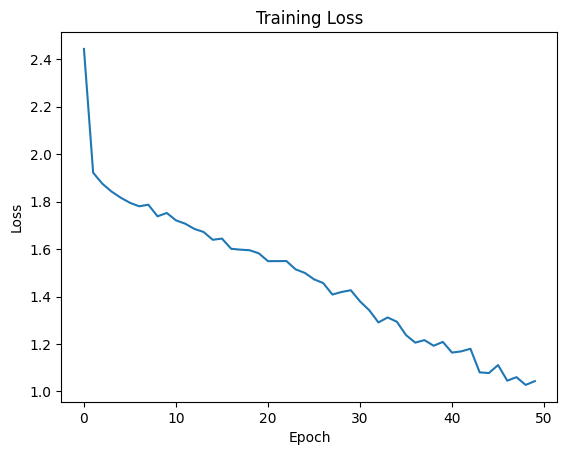

In [6]:
tokenizer = SimpleTokenizer(captions)
print(f"Vocab size: {tokenizer.vocab_size}")

# Dataset & Loader
dataset = ShapeDataset("data/dataset.json", tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model
model = NanoVLM(vocab_size=tokenizer.vocab_size).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop
loss_history = []

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for images, texts in pbar:
        images, texts = images.to(DEVICE), texts.to(DEVICE)

        optimizer.zero_grad()

        # Forward
        image_features, text_features = model(images, texts)

        # Calculate Logits
        # logits: [batch_size, batch_size]
        actuals = (image_features @ text_features.T) * torch.exp(model.temperature)

        # Labels: diagonal is the match
        targets = torch.arange(actuals.size(0)).to(DEVICE)

        # Loss: Average of Image-to-Text and Text-to-Image
        loss_i2t = nn.CrossEntropyLoss()(actuals, targets)
        loss_t2i = nn.CrossEntropyLoss()(actuals.T, targets)
        loss = (loss_i2t + loss_t2i) / 2

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

# Plot Loss
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 4. Demo & Visualization

Now let's test our model!

1.  **Text-to-Image**: We give the model a text query, and it retrieves the most similar images from the dataset.
2.  **Image-to-Text**: We give the model an image, and it ranks a set of candidate captions.


--- Text to Image Retrieval ---
Pre-computing image embeddings...

Query: 'a red circle at top left'


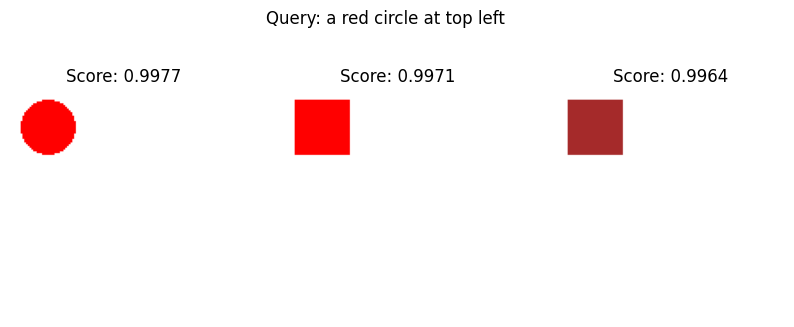


Query: 'a blue triangle at center center'


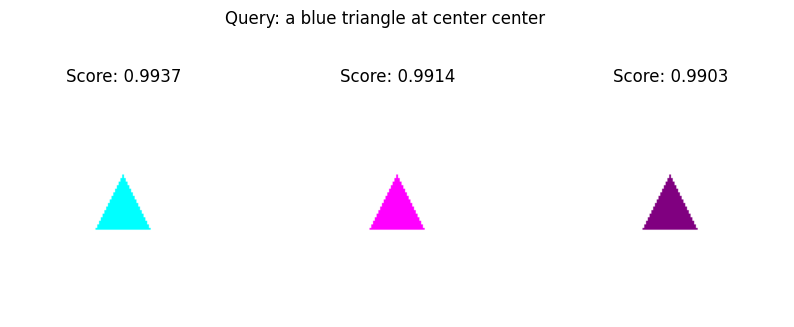


Query: 'a green square at bottom right'


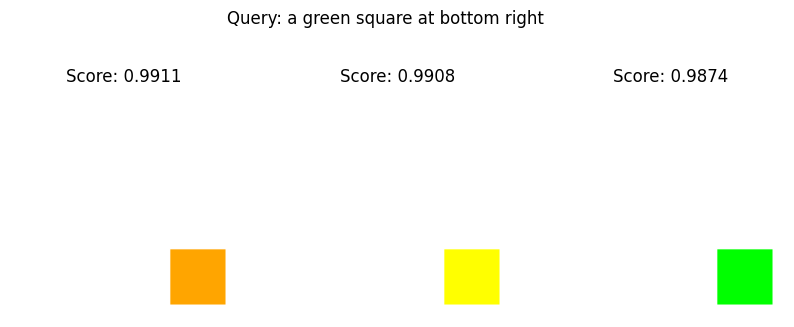


--- Image to Text (Zero-Shot Classification) ---
Selected Image: data/images/red_square_center_right.png (True: a red square at center right)
Predictions:
  a red square at center right: 0.7394
  a blue square at center center: 0.0637
  a red circle at top left: 0.0627
  a purple square at bottom left: 0.0541
  a green triangle at bottom right: 0.0427
  a yellow circle at top right: 0.0374


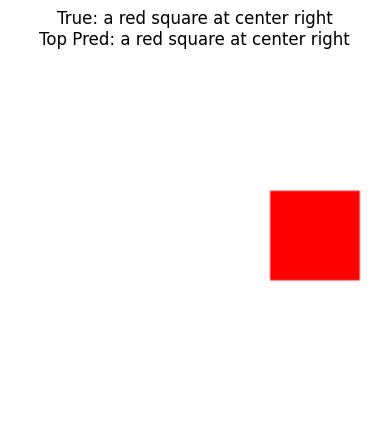

In [7]:
def get_image_embedding(model, image_path, transform):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        image_emb = model.image_encoder(image_tensor)
        image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)
    return image_emb, image

def get_text_embedding(model, tokenizer, text):
    tokens = torch.tensor(tokenizer.encode(text), dtype=torch.long).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        text_emb = model.text_encoder(tokens)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    return text_emb

def demo_text_to_image(model, tokenizer, dataset, queries):
    print("\n--- Text to Image Retrieval ---")
    transform = transforms.Compose([transforms.ToTensor()])

    # Pre-compute all image embeddings
    print("Pre-computing image embeddings...")
    image_embeddings = []
    image_paths = []

    # Use a subset if dataset is huge, but here it's small
    for item in dataset:
        path = item['image_path']
        emb, _ = get_image_embedding(model, path, transform)
        image_embeddings.append(emb)
        image_paths.append(path)

    image_embeddings = torch.cat(image_embeddings) # [N, dim]

    for query in queries:
        print(f"\nQuery: '{query}'")
        text_emb = get_text_embedding(model, tokenizer, query)

        # Similarity
        sims = (text_emb @ image_embeddings.T).squeeze()

        # Top 3
        topk = sims.topk(3)

        fig, axes = plt.subplots(1, 3, figsize=(10, 4))
        fig.suptitle(f"Query: {query}")

        for i, (score, idx) in enumerate(zip(topk.values, topk.indices)):
            img_path = image_paths[idx]
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Score: {score.item():.4f}")
            axes[i].axis('off')

        plt.show()

def demo_image_to_text(model, tokenizer, dataset):
    print("\n--- Image to Text (Zero-Shot Classification) ---")
    transform = transforms.Compose([transforms.ToTensor()])

    # Pick a random image
    item = random.choice(dataset)
    true_caption = item['caption']
    image_path = item['image_path']
    print(f"Selected Image: {image_path} (True: {true_caption})")

    image_emb, img = get_image_embedding(model, image_path, transform)

    # Create a set of candidate captions
    # Some random ones + the true one
    candidates = [
        "a red circle at top left",
        "a blue square at center center",
        "a green triangle at bottom right",
        "a yellow circle at top right",
        "a purple square at bottom left",
        true_caption # Ensure true one is there
    ]
    # Remove duplicates
    candidates = list(set(candidates))

    text_embeddings = []
    for txt in candidates:
        text_embeddings.append(get_text_embedding(model, tokenizer, txt))
    text_embeddings = torch.cat(text_embeddings)

    # Similarity
    sims = (image_emb @ text_embeddings.T).squeeze()
    probs = F.softmax(sims * model.temperature.exp(), dim=0)

    # Top candidates
    topk = probs.topk(len(candidates))

    print("Predictions:")
    for score, idx in zip(topk.values, topk.indices):
        print(f"  {candidates[idx]}: {score.item():.4f}")

    plt.imshow(img)
    plt.title(f"True: {true_caption}\nTop Pred: {candidates[topk.indices[0]]}")
    plt.axis('off')
    plt.show()

# Run Demos
with open("data/dataset.json", "r") as f:
    dataset_json = json.load(f)

model.eval()

# 1. Text to Image
queries = [
    "a red circle at top left",
    "a blue triangle at center center",
    "a green square at bottom right"
]
demo_text_to_image(model, tokenizer, dataset_json, queries)

# 2. Image to Text
demo_image_to_text(model, tokenizer, dataset_json)